## Download and Visualize Data

In [1]:
#!wget https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip
#!mkdir emojis
#!unzip -q openmoji-72x72-color.zip -d ./emojis
#!pip install tensorflow==2.4

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

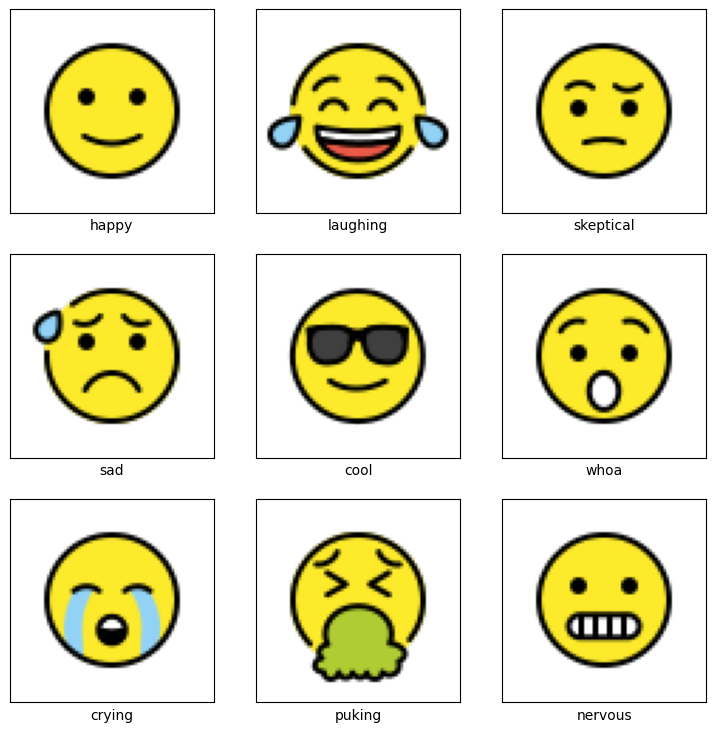

In [3]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Create Examples

In [4]:
for class_id, values in emojis.items():
   png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
   png_file.load()
   new_file = Image.new("RGB", png_file.size, (255, 255, 255))
   new_file.paste(png_file, mask=png_file.split()[3])
   emojis[class_id]['image'] = new_file

In [5]:
emojis

{0: {'name': 'happy',
  'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 1: {'name': 'laughing',
  'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 2: {'name': 'skeptical',
  'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 3: {'name': 'sad',
  'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 4: {'name': 'cool',
  'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 5: {'name': 'whoa',
  'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 6: {'name': 'crying',
  'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 7: {'name': 'puking',
  'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 8: {'name': 'nervous',
  'file': '1F62C.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>}}

In [6]:
def create_example():
   class_id = np.random.randint(0, 9)
   image = np.ones((144, 144, 3))* 255
   row = np.random.randint(0, 72)
   col = np.random.randint(0, 72)
   image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
   return image.astype('uint8'), class_id, (row + 10)/144, (col + 10)/144

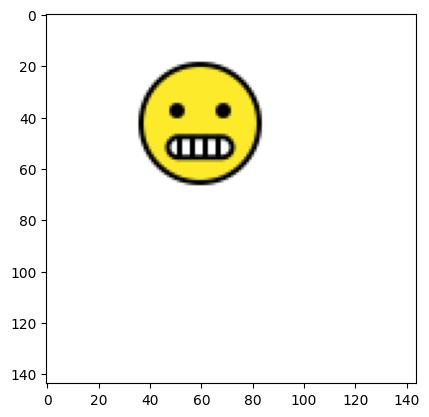

In [7]:
def create_example_safe():
	class_id = np.random.randint(0, 9)
	image = np.ones((144, 144, 3)) * 255
	row = np.random.randint(0, 144 - 72 + 1)
	col = np.random.randint(0, 144 - 72 + 1)
	image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
	return image.astype('uint8'), class_id, (row + 10) / 144, (col + 10) / 144

image, class_id, row, col = create_example_safe()
plt.imshow(image)

## Plot Bounding Boxes

In [8]:
def plot_bounding_box(image, gt_coords, pred_coords = None, norm = False):
	if norm:
		image *= 255
		image = image.astype('uint8')
	image = Image.fromarray(image)
	draw = ImageDraw.Draw(image)
   
	row,col = gt_coords
	row*= 144
	col*= 144
	draw.rectangle((col, row, col + 52, row + 52), outline = 'green', width = 3)

	if pred_coords is not None:
		row, col = pred_coords
		row *= 144
		col *= 144
		draw.rectangle((col, row, col + 52, row + 52), outline = 'red', width = 3)
	return image   

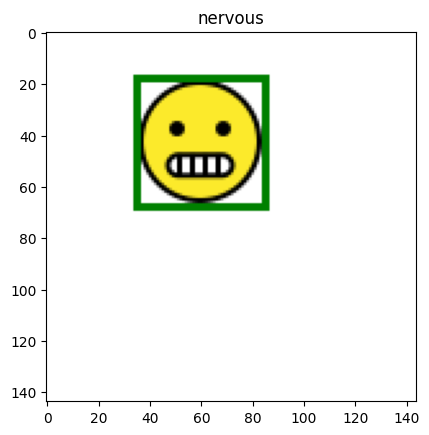

In [9]:
image = plot_bounding_box(image, gt_coords=[row, col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.imshow(image)

## Data Generator

In [10]:
def data_generator(batch_size = 16):
	while True:
		x_batch = np.zeros((batch_size,144,144,3))
		y_batch = np.zeros((batch_size, 9))
		box_batch = np.zeros((batch_size, 2))
   
		for i in range(0, batch_size):
			image, class_id, row, col = create_example_safe()
			x_batch[i] = image/255 
			y_batch[i, class_id] = 1.0
			box_batch[i] = np.array([row, col])
		yield {'image': x_batch}, {'class_out': y_batch, 'box_out': box_batch} 

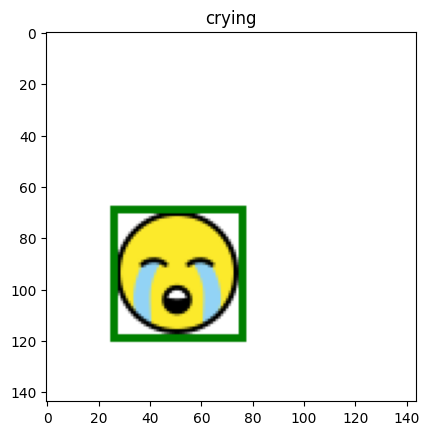

In [11]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm = True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Model

In [12]:
input_ = Input(shape=(144, 144, 3), name = 'image')

x = input_

for i in range(0,5):
   n_filters = 2**(4+i)
   x = Conv2D(n_filters, 3, activation = 'relu')(x)
   x = BatchNormalization()(x)
   x = MaxPool2D(2)(x)
   
x = Flatten()(x)
x = Dense(256, activation = 'relu')(x)

class_out = Dense(9, activation = 'softmax', name = 'class_out')(x)
box_out = Dense(2, name = 'box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 144, 144,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 142, 142,  │        448 │ image[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 142, 142,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 71, 71,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 69, 69,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 69, 69,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 34, 34,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 5, 5, 256) │    295,168 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 256) │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 2, 2, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 659,819 (2.52 MB)

 Trainable params: 658,827 (2.51 MB)

 Non-trainable params: 992 (3.88 KB)

## Custom Metric: IoU

In [13]:
class IoU(tf.keras.metrics.Metric):
	def __init__(self, **kwargs):
		super(IoU, self).__init__(**kwargs)
      
		self.iou = self.add_weight(name = 'iou', initializer='zeros')
		self.total_iou = self.add_weight(name = 'total_iou', initializer='zeros')
		self.num_ex = self.add_weight(name = 'num_ex', initializer='zeros')

	def update_state(self, y_true, y_pred, sample_weight=None):
		def get_box(y):
			rows, cols = y[:, 0], y[:, 1]
			rows, cols = rows*144, cols*144
			y1, y2 = rows, rows+52
			x1, x2 = cols, cols+52
			return x1, y1, x2, y2
		
		def get_area(x1, y1, x2, y2):
			return tf.math.abs(x2-x1)*tf.math.abs(y2-y1)
		
		gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
		p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

		i_x1 = tf.maximum(gt_x1, p_x1)
		i_y1 = tf.maximum(gt_y1, p_y1)
		i_x2 = tf.minimum(gt_x2, p_x2)
		i_y2 = tf.minimum(gt_y2, p_y2)

		i_area = get_area(i_x1, i_y1, i_x2, i_y2)
		u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

		iou = tf.math.divide(i_area, u_area)
		self.num_ex.assign_add(1)
		self.total_iou.assign_add(tf.reduce_mean(iou))
		self.iou = tf.math.divide(self.total_iou, self.num_ex)

	def result(self):
		return self.iou
	
	def reset_state(self):
		self.iou = self.add_weight(name='iou', initializer='zeros')
		self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
		self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

## Compile the Model

In [14]:
model.compile(
   loss={
			'class_out': 'categorical_crossentropy',
         'box_out': 'mse'
	},
   optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
   metrics={
				'class_out': 'accuracy',
				'box_out': IoU(name = 'IoU')
	}
)

## Custom Callback: Model Testing

In [15]:
def test_model(model, test_datagen):
	example, label = next(test_datagen)
	x = example['image']
	y = label['class_out']
	box = label['box_out']
   
	pred_y, pred_box = model.predict(x)

	pred_coords = pred_box[0]
	gt_coords = box[0]
	pred_class = np.argmax(pred_y[0])
	image = x[0]

	gt = emojis[np.argmax(y[0])]['name']
	pred_class_name = emojis[pred_class]['name']

	image = plot_bounding_box(image, gt_coords, pred_coords, norm = True)
	color = 'green' if gt == pred_class_name else 'red'

	plt.imshow(image)
	plt.xlabel(f"Pred: {pred_class_name}", color = color)
	plt.ylabel(f"GT: {gt}", color = color)
	plt.xticks([])
	plt.yticks([]) 

In [16]:
def test(model):
	test_datagen = data_generator(1)
   
	plt.figure(figsize=(16,4))
   
	for i in range(0,6):
		plt.subplot(1, 6, i+1)
		test_model(model, test_datagen)
	plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


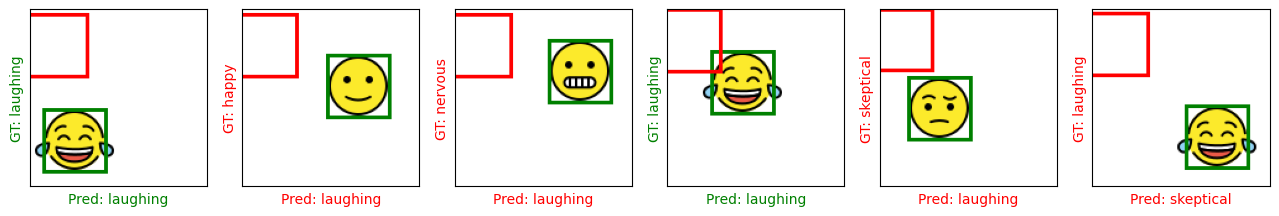

In [17]:
test(model)

In [18]:
class ShowTestImages(tf.keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs = None):
      test(self.model)

## Task 10: Model Training

In [33]:
history = model.fit(
	data_generator(),
	steps_per_epoch=steps_per_epoch,
	epochs=epochs,
	callbacks=callbacks
)

Epoch 1/50


ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.

## Summary

This notebook demonstrates an end-to-end workflow for training a deep learning model to detect and classify emoji images with bounding box localization. The main steps include:

- **Data Preparation:** Emoji images are downloaded, extracted, and visualized. Each emoji is assigned a class label and stored in a dictionary.
- **Example Generation:** Functions create synthetic images by placing a random emoji at a random location on a blank canvas, returning both the image and normalized bounding box coordinates.
- **Visualization:** Bounding boxes are drawn on images to visualize ground truth and predictions.
- **Data Generator:** A generator yields batches of images, class labels (one-hot), and bounding box coordinates for model training.
- **Model Architecture:** A convolutional neural network is built using Keras, with two outputs: one for emoji classification and one for bounding box regression.
- **Custom Metric:** Intersection over Union (IoU) is implemented as a custom metric to evaluate bounding box predictions.
- **Training:** The model is compiled and trained with callbacks for early stopping, learning rate scheduling, and visualization of predictions after each epoch.
- **Testing:** Custom functions visualize model predictions and compare them to ground truth during and after training.

This workflow provides a practical example of multi-task learning for image classification and localization using TensorFlow/Keras.